In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
import tensorflow as tf
import keras
from sklearn.metrics import mean_squared_error, r2_score

## Data loading and analysis

In [3]:
ref = pd.read_json('referate-train.json')

<AxesSubplot:ylabel='Count'>

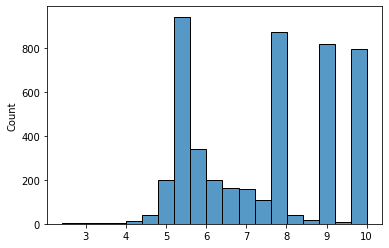

In [4]:
sns.histplot(ref['grade'].values)

In [5]:
lengths = [len(x) for x in ref['text'].values]
sns.histplot(lengths)

In [101]:
train = pd.read_json('referate-train-embeddings.json')
X = train['embeddings'].values
y = train['grade'].values
X = np.array([np.array(x) for x in X])

In [102]:
referate_dev = pd.read_json('referate-dev-embeddings.json')
X_dev = referate_dev['embeddings'].values
y_dev = referate_dev['grade'].values
X_dev = np.array([np.array(x) for x in X_dev])

## Linear Regression

In [103]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
lin_reg.fit(X, y)

LinearRegression(n_jobs=-1, normalize=True)

In [ ]:
output_lin = lin_reg.predict(X_dev)
mean_squared_error(y_dev, output_lin)

## Support Vector Machine

In [ ]:
regressor = SVR(kernel='rbf')
regressor.fit(X,y)

In [69]:
output = regressor.predict(data=X_dev)
mean_squared_error(y_dev, output)

4.0701298227461145

## XGBoost + GridSearch

In [ ]:
model = xgb.XGBRegressor(learning_rate = 0.02)

parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train_full,
         y_train_full)

In [83]:
out = xgb_grid.predict(X_dev)
mean_squared_error(y_dev, out)

3.535718939888991

## Inference

In [106]:
test = pd.read_json('referate-test.json')
test_embeddings = pd.read_json('referate-test-embeddings.json')
X = test_embeddings['embeddings'].values
X = np.array([np.array(x) for x in X])

In [107]:
test['grade'] = lin_reg.predict(X)

In [108]:
test

,index,filename,text,category,grade
0,1420,"Referat Ultima noapte de dragoste, intaia noap...",Elemente de noutate in estetica romanului Rom...,romana,7.106718
1,1549,Referat Stiluri de viata in Romania,AZTECI \nAztecii au fost membrii uneia dintre ...,psihologie,7.969465
2,1265,Modernizare-turcia,Efortul de modernizare în Turcia în perioada i...,istorie,8.076013
3,5291,Luceafarul - Comentariu Var-1,LUCEAFĂRUL Despre felul cum s-a născut marele ...,romana,7.419366
4,791,Referat Scurta istorie a bombei,Bombele atomice lansate de catre Statele Unite...,istorie,7.542830
...,...,...,...,...,...
495,3591,Morometi,Morometii \n-Personaje principale \n -Parin...,romana,7.244297
496,5389,Padurea Spanzuratilor - Comentariu,Padurea spanzuratilor de Liviu Rebreanu \nTema...,romana,7.534710
497,1496,Referat Marsul lui Radetzky,MARELE ZID CHINEZESC \n Constructie gi...,istorie,7.696005
498,911,Referat Ciresarii - Cavalerii florii de cires,A Z U G A Valea Prahovei a ...,romana,8.113847


In [109]:
test.to_json('referate_test.json')

## Neural Network (pure experiment)

In [133]:
model = keras.Sequential([
    keras.layers.Dense(512, input_dim = X.shape[1], kernel_initializer = 'normal', activation = 'relu'),
    keras.layers.Dense(512, kernel_initializer = 'normal', activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(128, kernel_initializer = 'normal', activation = 'relu'),
    keras.layers.Dense(128, kernel_initializer = 'normal', activation = 'relu'),
    keras.layers.Dense(64, kernel_initializer = 'normal', activation = 'relu'),
    keras.layers.Dense(64, kernel_initializer = 'normal', activation = 'relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, kernel_initializer = 'normal', activation = 'linear')
])

In [134]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 512)               102912    
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_52 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_53 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_54 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_56 (Dense)             (None, 64)               

In [157]:
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.02), metrics=['mean_squared_error'])

In [158]:
history = model.fit(x_scaled, y, epochs = 100, batch_size = 64, validation_data = (x_val_scaled, y_dev))

Epoch 1/100
74/74 [==============================] - 0s 4ms/step - loss: 3.0822 - mean_squared_error: 3.0822 - val_loss: 3.1733 - val_mean_squared_error: 3.1733
Epoch 2/100
74/74 [==============================] - 0s 4ms/step - loss: 3.0803 - mean_squared_error: 3.0803 - val_loss: 3.1625 - val_mean_squared_error: 3.1625
Epoch 3/100
74/74 [==============================] - 0s 4ms/step - loss: 3.0811 - mean_squared_error: 3.0811 - val_loss: 3.1647 - val_mean_squared_error: 3.1647
Epoch 4/100
74/74 [==============================] - 0s 4ms/step - loss: 3.0812 - mean_squared_error: 3.0812 - val_loss: 3.1654 - val_mean_squared_error: 3.1654
Epoch 5/100
74/74 [==============================] - 0s 4ms/step - loss: 3.0823 - mean_squared_error: 3.0823 - val_loss: 3.1703 - val_mean_squared_error: 3.1703
Epoch 6/100
74/74 [==============================] - 0s 4ms/step - loss: 3.0812 - mean_squared_error: 3.0812 - val_loss: 3.1660 - val_mean_squared_error: 3.1660
Epoch 7/100
74/74 [===============

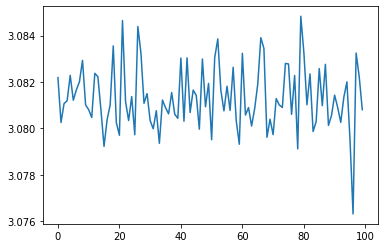

In [160]:
plt.plot(history.history['loss'])

In [149]:
o = model.predict(X_dev)

In [61]:
o[o > 10] = 10

In [145]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_x.fit(X)
x_scaled = scaler_x.transform(X)
x_val_scaled = scaler_x.transform(X_dev)